In [2]:
import pandas as pd
import sklearn as sk
import numpy as np

#below packages are only needed for AWS notebooks
#import boto3 
#from sagemaker import get_execution_role

### Data Prep [AWS Environments ONLY]

In [2]:
import os
import multiprocessing

# Get the number of CPU cores
num_cpus = os.cpu_count()

# Get the number of CPU threads using multiprocessing
num_threads = multiprocessing.cpu_count()

print(f"Number of CPU cores: {num_cpus}")
print(f"Number of CPU threads: {num_threads}")

Number of CPU cores: 8
Number of CPU threads: 8


In [3]:
conn = boto3.client('s3')
bucket = 'wonkas-golden-bucket'
content = conn.list_objects(Bucket=bucket)["Contents"]
content

[{'Key': 'movies.csv',
  'LastModified': datetime.datetime(2023, 11, 28, 23, 42, 57, tzinfo=tzlocal()),
  'ETag': '"23b066571ca80fc78947840b05ac57b4"',
  'Size': 1397542,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': 'omarmoore',
   'ID': '032fdca6c289ca07d1afb22f50e3165f19ef8a4ffd5aafc2e9c8616bdade34c3'}},
 {'Key': 'movies_metadata.csv',
  'LastModified': datetime.datetime(2023, 11, 28, 23, 42, 56, tzinfo=tzlocal()),
  'ETag': '"cdca6fe4090717ea20672fc78547df65-3"',
  'Size': 34445126,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': 'omarmoore',
   'ID': '032fdca6c289ca07d1afb22f50e3165f19ef8a4ffd5aafc2e9c8616bdade34c3'}},
 {'Key': 'ratings.csv',
  'LastModified': datetime.datetime(2023, 11, 28, 23, 42, 56, tzinfo=tzlocal()),
  'ETag': '"e58ab80b3222930f6c623a71029c5fc1-32"',
  'Size': 533444411,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': 'omarmoore',
   'ID': '032fdca6c289ca07d1afb22f50e3165f19ef8a4ffd5aafc2e9c8616bdade34c3'}}]

In [42]:
for data in content:
    print(data['Key'])

movies.csv
movies_metadata.csv
ratings.csv


In [5]:
df1 = "movies.csv"
df2 = 'movies_metadata.csv'
df3 = "ratings.csv"

films = pd.read_csv(f"s3://{bucket}/{df1}")

metadata = pd.read_csv(f"s3://{bucket}/{df2}")

ratings = pd.read_csv(f"s3://{bucket}/{df3}")

films['title'] = films['title'].str[:-7] #early cleaning needed to be able to join on movie titles

#Merge Tables

new_merge =  films.merge(metadata, left_on='title', right_on='original_title', how='inner')

final_merge = new_merge.merge(ratings, on='movieId', how='inner')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)
/tmp/ipykernel_11508/553697495.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"s3://{bucket}/{df2}")


### Load Data [LOCALLY]

In [3]:
#Load Data

films = pd.read_csv('/Users/omarmoore/research/film_data/movies.csv')

metadata = pd.read_csv('/Users/omarmoore/research/film_data/movies_metadata.csv')

ratings = pd.read_csv("/Users/omarmoore/research/film_data/ratings.csv")

films['title'] = films['title'].str[:-7] #early cleaning needed to be able to join on movie titles

#Merge Tables

new_merge =  films.merge(metadata, left_on='title', right_on='original_title', how='inner')

final_merge = new_merge.merge(ratings, on='movieId', how='inner')

/var/folders/j8/qk3qs96x2mg8j_pp6thc7r280000gn/T/ipykernel_12268/2023164815.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/Users/omarmoore/research/film_data/movies_metadata.csv')


In [4]:
final_merge.shape
# final dataframe consists of 16 million reviews

(16024934, 30)

### Feature Engineering

In [12]:
#CLEAN/PreProcess Data

# convert some predictors to appropriate formats

# Encode genres_x
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
final_merge['genres_x_encoded'] = label_encoder.fit_transform(final_merge['genres_x'])
final_merge['release_year'] = pd.to_datetime(final_merge['release_date']).dt.year
final_merge.dropna(subset=['release_year'], inplace=True)
final_merge['release_year'] = final_merge['release_year'].astype(int)
final_merge['popularity'] = final_merge['popularity'].astype(float).astype(int)

In [13]:
# Beginning a subset for working on local machine. Start with aggregating duplicate ratings. 

df_agg = final_merge.groupby(['movieId', 'userId']).agg({'rating': 'mean', 'timestamp': 'mean', 'popularity': 'mean', 'runtime': 'mean', 'release_year': 'mean', 'genres_x_encoded': 'mean', 'vote_count': 'mean'}).reset_index()

df_sorted = df_agg.sort_values('timestamp', ascending=True)

# subset_df = df_sorted.head(100)

sub_split_test = df_sorted.head(1000000)

### Train/Test Split

In [14]:
test_size = 200000

train = sub_split_test.iloc[:-test_size, :]
test = sub_split_test.iloc[-test_size:, :]

print(f"Train set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

## this is maybe worth removing

Train set shape: (800000, 9)
Test set shape: (200000, 9)


In [15]:
#SPLIT the data/Testing dimensionality changes

#i dont think we use this split anymore, new split is in below cell.
#train_path = subset_df.sample(frac=0.8, random_state=42)
#test_path = subset_df.drop(train_path.index)

In [16]:
x_train = train[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
y_train = train['rating']
x_test = test[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
y_test = test['rating']

## Model 1: Content-Based Recommender

In [17]:
#%pip install xgboost

In [38]:
import xgboost as xgb

model1 = xgb.XGBRegressor(objective='reg:squarederror') #discuss params and args in paper
# use below line on aws to access GPU
#model1 = xgb.XGBRegressor(objective='reg:squarederror', device = "cuda") #discuss params and args in paper
model1.fit(x_train, y_train)

# Make predictions on the test data
pred1 = model1.predict(x_test)

In [39]:
# calculate the root mean squared error (RMSE)
rmseContent = np.sqrt(np.mean((pred1 - y_test)**2))
print(f'content-based rmse = {rmseContent}')

content-based rmse = 0.9227319905622696


### Model 2: Data Prep

In [20]:
subset_df = sub_split_test.groupby(['movieId', 'userId']).agg({'rating': 'mean', 'timestamp': 'mean', 'popularity': 'mean', 'runtime': 'mean', 'release_year': 'mean', 'genres_x_encoded': 'mean', 'vote_count': 'mean'}).reset_index()
# maybe remove

In [21]:
#pivot dataframe to utility matrix
utility = subset_df.pivot(index='movieId', columns='userId', values='rating')
utility = utility.fillna(0)
utility.head(10)

userId,4,8,15,26,28,29,32,34,38,46,...,138431,138442,138447,138448,138452,138453,138463,138483,138484,138488
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,5.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0
3,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,...,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,5.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#condensed distance matrix

from scipy.spatial.distance import pdist, squareform
distance_mtx = squareform(pdist(utility, 'cosine'))

#a square matrix where each element represents the cosine similarity between movie and user rating.

similarity_mtx = 1 - distance_mtx

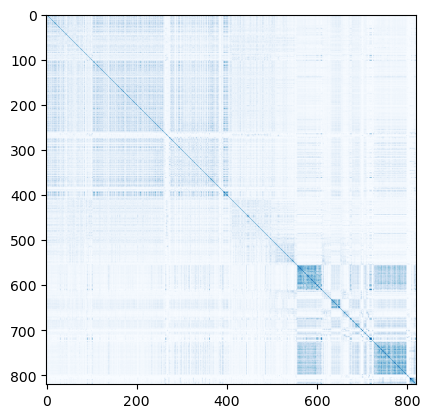

In [23]:
import matplotlib.pyplot as plt

plt.imshow(similarity_mtx, cmap = 'Blues')

In [24]:
#select ratings of a userId and the similarity scores for a movieId
user_to_predict = 9
movie_to_predict = 3

user_ratings = utility.iloc[:, user_to_predict-1]
movie_similarity = similarity_mtx[movie_to_predict-1]

In [25]:
#begin predictions

numerator = np.dot(user_ratings, movie_similarity)
denominator = movie_similarity[user_ratings > 0].sum() #removing 0 ratings if any left
pred_score = numerator / denominator

pred_score

#prediction is 3.4 vs actual rating of 3.0

3.453735949114871

In [26]:
#turn prediction into function
def predict_rating(userId, movieId, similarity_mtx, utility):
    #user_ratingsX = utilityX.iloc[:, userId-1]
    user_ratings = utility[userId]
    movie_index = list(utility.index).index(movieId)
    movie_similarity = similarity_mtx[movie_index]
    numerate = np.dot(user_ratings, movie_similarity)
    denom = movie_similarity[user_ratings > 0].sum()
    
    if denom == 0 or numerate == 0:
        return user_ratings[user_ratings > 0].mean()
    
    return numerate / denom

predict_rating(38,3, similarity_mtx, utility)

3.453735949114871

### Train/Test Split

In [27]:
#testing the model

#test_set = test_path[['userId', 'movieId']].to_numpy()
#test_real = test_path['rating'].to_numpy()


test_set = test[['userId', 'movieId']].to_numpy()
test_real = test['rating'].to_numpy()


In [28]:
pred2 = []
for data in test_set:
    res = predict_rating(data[0], data[1], similarity_mtx, utility)
    pred2.append(res)

In [29]:
rmseCollab = np.sqrt(np.mean((test_real - pred2)**2))
print(f'RMSE = {rmseCollab}')

RMSE = 0.8586134218498944


## Model 3: Hybrid System

In [30]:
pred1 = np.array(pred1)
pred2 = np.array(pred2)

In [31]:
len(pred2)

200000

In [32]:
#Initially used an array to test different weight. 
chart_val = []
weights = np.linspace(0, 1, 21)

for weight in weights:
    pred_hybrid = pred1 * weight + pred2 * (1 - weight)
    rmse_hybrid = np.sqrt(np.mean((pred_hybrid - test_real)**2))
    chart_val.append([weight, rmse_hybrid])

chart_val_np = np.array(chart_val)

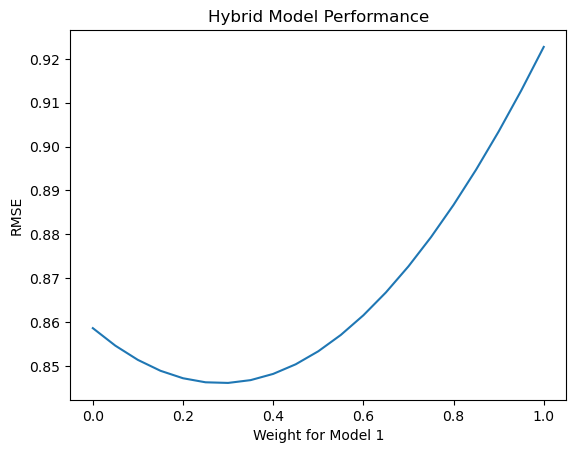

In [33]:
plt.plot(chart_val_np[:, 0], chart_val_np[:, 1])
plt.xlabel('Weight for Model 1')
plt.ylabel('RMSE')
plt.title('Hybrid Model Performance')
plt.show()

In [34]:
chart_val_np

array([[0.        , 0.85861342],
       [0.05      , 0.85461149],
       [0.1       , 0.85136797],
       [0.15      , 0.84889158],
       [0.2       , 0.84718903],
       [0.25      , 0.84626499],
       [0.3       , 0.84612202],
       [0.35      , 0.84676051],
       [0.4       , 0.8481787 ],
       [0.45      , 0.85037268],
       [0.5       , 0.85333647],
       [0.55      , 0.85706209],
       [0.6       , 0.86153965],
       [0.65      , 0.8667575 ],
       [0.7       , 0.87270236],
       [0.75      , 0.87935948],
       [0.8       , 0.88671283],
       [0.85      , 0.89474524],
       [0.9       , 0.90343859],
       [0.95      , 0.912774  ],
       [1.        , 0.92273199]])

In [35]:
#checked the chart_val_np df to find weights with lowest error

w1 = 0.25

w2 = 1 - w1

hybrid_mod = pred1 * w1 + pred2 * w2
rmseHybrid = np.sqrt(np.mean((test_real - hybrid_mod)**2))

### Model Evaluation

In [36]:
print(f'Content RMSE = {rmseContent}')
print(f'Collab RMSE = {rmseCollab}')
print(f'Hybrid RMSE = {rmseHybrid}')
#the recommender learns new information from each model and ultimately is the most accurate with a combination of both methods. 

#will need to test this with more data for the hyrbid model portion.

Content RMSE = 0.9227319905622696
Collab RMSE = 0.8586134218498944
Hybrid RMSE = 0.8462649930248349


In [62]:
from scipy.spatial.distance import pdist, squareform

## now on new instance advanced compute. horizon = 20000 with skips = 1000 yields RMSE of 0.9469 in 70 secs
# skips = 10 gets RMSE of 0.8936381778717041 takes 2 min
# n = 100000 and skips = 100 takes 16 minutes with RMSE of 0.8400000000000002

subset_df = sub_split_test.sample(n=100000, random_state=42)

subset_df = subset_df.sort_values('timestamp', ascending=True)

initial_train_size = 80000
horizon = 20000


train = subset_df.reset_index()

rmse_list1 = []

rmse_list2 = []

rmse_list_hybrid = []

pred1_list = []
pred2_list = []
actual_ratings_list = []

for i in range(0, len(train) - initial_train_size - 1, 100):
    subset_train = train.loc[i : i + initial_train_size - 1]
    subset_train = subset_train.reset_index().drop('index', axis=1)
    subset_test = train.loc[i + initial_train_size : i + initial_train_size]
    subset_test = subset_test.reset_index().drop('index', axis=1)
#for i in range(len(train) - initial_train_size - 1):
#    subset_train = train.loc[0 : i + initial_train_size - 1]
#    subset_train = subset_train.reset_index().drop('index', axis=1)
#    subset_test = train.loc[i + initial_train_size : i + initial_train_size]
#    subset_test = subset_test.reset_index().drop('index', axis=1)
    xtrain = subset_train[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
    ytrain = subset_train[['rating']]
    xtest = subset_test[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
    ytest = subset_test[['rating']]
    model1.fit(xtrain, ytrain)
    pred = model1.predict(xtest)
    RMSE1 = np.sqrt(np.mean((pred - ytest)**2))
    #calculate rmse
    rmse_list1.append(RMSE1)
    pred1_list.append(pred)


# for i in range(len(train) - window):
    subset_train = train.loc[0 : i + initial_train_size - 1]
    subset_train = subset_train.reset_index().drop('index', axis=1)
    subset_test = train.loc[i + initial_train_size : i + initial_train_size]
    subset_test = subset_test.reset_index().drop('index', axis=1)
    utility = subset_train.groupby(['movieId', 'userId']).agg({'rating': 'mean', 'popularity': 'mean', 'runtime': 'mean', 'release_year': 'mean', 'genres_x_encoded': 'mean', 'vote_count': 'mean'}).reset_index()
    utility = utility.pivot(index='movieId', columns='userId', values='rating')
    utility = utility.fillna(0).reset_index()
    #condensed distance matrix
    distance_mtx = squareform(pdist(utility, 'cosine'))
    #a square matrix where each element represents the cosine similarity between movie and user rating.
    similarity_mtx = 1 - distance_mtx
    similarity_df = pd.DataFrame(similarity_mtx)
    # similarity_df['movieId'] = utility['']
    subset_test['score'] = np.nan
    for i in range(len(subset_test)):
        review = subset_test.loc[i]
        user = review['userId']
        if user in utility.columns:
            user_ratings = utility[user]
            if len(utility[utility['movieId']== review['movieId']])==0:
                subset_test.loc[i, 'score'] = 3
            else:  
                idx = utility[utility['movieId']== review['movieId']].index[0]
                movie_similarity = similarity_mtx[idx]
                numerator = np.dot(user_ratings, movie_similarity)
                denominator = movie_similarity[user_ratings > 0].sum()
                subset_test.loc[i,'score'] = numerator/denominator
        else:
            subset_test.loc[i, 'score'] = 3 #revisit later
    RMSE2 = np.sqrt(np.mean((subset_test['score'] - subset_test['rating'])**2))
    rmse_list2.append(RMSE2)   
        #pred2_fold = np.array(pred2_fold)
    pred2_list.append(subset_test['score'])

    # Hybrid Model (weighted combo)
    w1 = 0.3
    w2 = 1 - w1

    pred1 = np.array(pred1_list)
    pred2 = np.array(pred2_list)   
    hybrid_mod_fold = pred1 * w1 + pred2 * w2

    rmse_fold = np.sqrt(np.mean((hybrid_mod_fold[0][0] - subset_test['rating'])**2))
    actual_ratings_list.append(subset_test['rating'].values[0])
    rmse_list_hybrid.append(rmse_fold)
# results for each fold

# fold_results = pd.DataFrame({'userId': ['userId'],
#                                   'movieId': ['movieId'],
#                                   'actual_rating': ['rating'],
#                                   'pred1': RMSE1,
#                                   'pred2': RMSE2,
#                                   'hybrid_prediction': hybrid_mod_fold})

# results_list.append(fold_results)

# RMSE across folds
np.mean(rmse_list_hybrid)


0.8400000000000002

In [41]:
from scipy.spatial.distance import pdist, squareform

# following benchmarks were recorded while using an ml.t3.2xlarge instance.
#testing on sample of 100 rows with horizon = 20 takes 1 second - average rmse: 1.0
#testing on sample of 1000 rows with horizon = 200 takes 26 seconds - average rmse: 0.845007214307785
#testing on sample of 10000 rows with horizon = 2000 takes 912 seconds - average rmse: 0.8387493799686434

# new instance
# horizon = 20 is 1 to 4 seconds
# horizon = 200 is 17 seconds

subset_df = sub_split_test.sample(n=1000, random_state = 42)

subset_df = subset_df.sort_values('timestamp', ascending=True)


window = 800
horizon = 200

pred1_list = []

train = subset_df.reset_index()

rmse_list1 = []


for i in range(0, len(train) - initial_train_size - 1, 20):
    subset_train = train.loc[i : i + initial_train_size - 1]
    subset_train = subset_train.reset_index().drop('index', axis=1)
    subset_test = train.loc[i + initial_train_size : i + initial_train_size]
    subset_test = subset_test.reset_index().drop('index', axis=1)
    
for i in range(len(train) - window):
    subset_train = train.loc[i : i + window - 1]
    subset_train = subset_train.reset_index().drop('index', axis=1)
    subset_test = train.loc[i + window : i + window]
    subset_test = subset_test.reset_index().drop('index', axis=1)
    xtrain = subset_train[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
    ytrain = subset_train[['rating']]
    xtest = subset_test[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
    ytest = subset_test[['rating']]
    model1.fit(xtrain, ytrain)
    pred = model1.predict(xtest)
    RMSE1 = np.sqrt(np.mean((pred - ytest)**2))
    #calculate rmse
    rmse_list1.append(RMSE1)
    pred1_list.append(pred)



# results for each fold

# fold_results = pd.DataFrame({'userId': ['userId'],
#                                   'movieId': ['movieId'],
#                                   'actual_rating': ['rating'],
#                                   'pred1': RMSE1,
#                                   'pred2': RMSE2,
#                                   'hybrid_prediction': hybrid_mod_fold})

# results_list.append(fold_results)

# RMSE for the fold
    



In [34]:
def Average(lst): 
    return sum(lst) / len(lst)

### Cross Validation: Sliding Window

In [31]:
from scipy.spatial.distance import pdist, squareform

# following benchmarks were recorded while using an ml.t3.2xlarge instance.
#testing on sample of 100 rows with horizon = 20 takes 1 second - average rmse: 1.0
#testing on sample of 1000 rows with horizon = 200 takes 26 seconds - average rmse: 0.845007214307785
#testing on sample of 10000 rows with horizon = 2000 takes 912 seconds - average rmse: 0.8387493799686434

# new instance
# horizon = 20 is 1 to 4 seconds
# horizon = 200 is 17 seconds

subset_df = sub_split_test.sample(n=10000, random_state = 42)

subset_df = subset_df.sort_values('timestamp', ascending=True)


window = 8000
horizon = 2000


train = subset_df.reset_index()

rmse_list1 = []

rmse_list2 = []

rmse_list_hybrid = []

pred1_list = []
pred2_list = []
actual_ratings_list = []

for i in range(len(train) - window):
    subset_train = train.loc[i : i + window - 1]
    subset_train = subset_train.reset_index().drop('index', axis=1)
    subset_test = train.loc[i + window : i + window]
    subset_test = subset_test.reset_index().drop('index', axis=1)
    xtrain = subset_train[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
    ytrain = subset_train[['rating']]
    xtest = subset_test[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
    ytest = subset_test[['rating']]
    model1.fit(xtrain, ytrain)
    pred = model1.predict(xtest)
    RMSE1 = np.sqrt(np.mean((pred - ytest)**2))
    #calculate rmse
    rmse_list1.append(RMSE1)
    pred1_list.append(pred)


# for i in range(len(train) - window):
    subset_train = train.loc[i : i + window - 1]
    subset_train = subset_train.reset_index().drop('index', axis=1)
    subset_test = train.loc[i + window : i + window]
    subset_test = subset_test.reset_index().drop('index', axis=1)
    utility = subset_train.groupby(['movieId', 'userId']).agg({'rating': 'mean', 'popularity': 'mean', 'runtime': 'mean', 'release_year': 'mean', 'genres_x_encoded': 'mean', 'vote_count': 'mean'}).reset_index()
    utility = utility.pivot(index='movieId', columns='userId', values='rating')
    utility = utility.fillna(0).reset_index()
    #condensed distance matrix
    distance_mtx = squareform(pdist(utility, 'cosine'))
    #a square matrix where each element represents the cosine similarity between movie and user rating.
    similarity_mtx = 1 - distance_mtx
    similarity_df = pd.DataFrame(similarity_mtx)
    # similarity_df['movieId'] = utility['']
    subset_test['score'] = np.nan
    for i in range(len(subset_test)):
        review = subset_test.loc[i]
        user = review['userId']
        if user in utility.columns:
            user_ratings = utility[user]
            if len(utility[utility['movieId']== review['movieId']])==0:
                subset_test.loc[i, 'score'] = 3
            else:  
                idx = utility[utility['movieId']== review['movieId']].index[0]
                movie_similarity = similarity_mtx[idx]
                numerator = np.dot(user_ratings, movie_similarity)
                denominator = movie_similarity[user_ratings > 0].sum()
                subset_test.loc[i,'score'] = numerator/denominator
        else:
            subset_test.loc[i, 'score'] = 3 #revisit later
    RMSE2 = np.sqrt(np.mean((subset_test['score'] - subset_test['rating'])**2))
    rmse_list2.append(RMSE2)   

    #pred2_fold = np.array(pred2_fold)
    pred2_list.append(subset_test['score'])

    # Hybrid Model (weighted combo)
    w1 = 0.3
    w2 = 1 - w1

    pred1 = np.array(pred1_list)
    pred2 = np.array(pred2_list)   
    hybrid_mod_fold = pred1 * w1 + pred2 * w2

    rmse_fold = np.sqrt(np.mean((hybrid_mod_fold[0][0] - subset_test['rating'])**2))
    actual_ratings_list.append(subset_test['rating'].values[0])
    rmse_list_hybrid.append(rmse_fold)
# results for each fold

# fold_results = pd.DataFrame({'userId': ['userId'],
#                                   'movieId': ['movieId'],
#                                   'actual_rating': ['rating'],
#                                   'pred1': RMSE1,
#                                   'pred2': RMSE2,
#                                   'hybrid_prediction': hybrid_mod_fold})

# results_list.append(fold_results)

# RMSE for the fold
    



In [38]:
def Average(lst): 
    return sum(lst) / len(lst)

Average(rmse_list_hybrid)

0.8224877156956459

### Cross Validation: Rolling Origin

In [40]:
rmse_list1

[0.3609461784362793,
 0.8029022216796875,
 0.731503963470459,
 0.2514326572418213,
 0.6162660121917725,
 0.6494646072387695,
 0.24659967422485352,
 1.2790412902832031,
 1.643721342086792,
 1.3290553092956543,
 0.6028175354003906,
 0.5501298904418945,
 0.356126070022583,
 0.13176822662353516,
 1.5040526390075684,
 0.650317907333374,
 0.27602720260620117,
 0.6763932704925537,
 0.06209993362426758,
 3.0446672439575195]

In [ ]:
subset_train

In [ ]:
Average(rmse_list_hybrid)

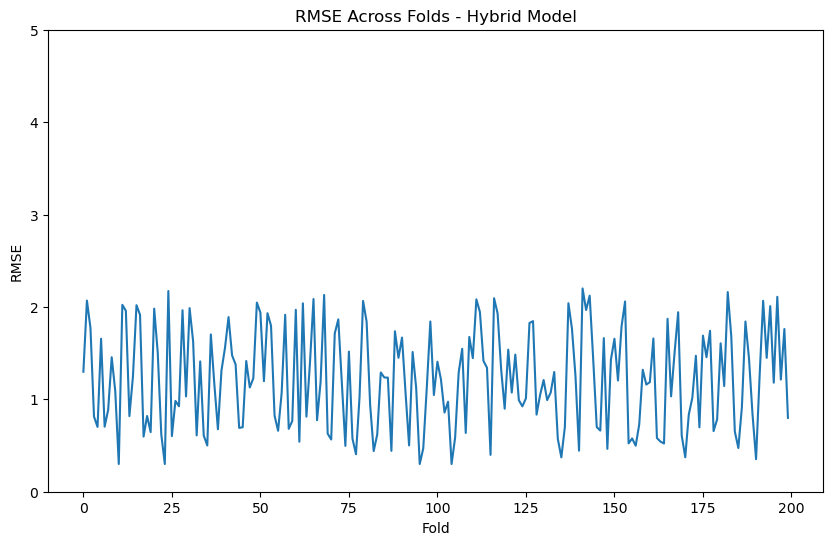

In [20]:
import matplotlib.pyplot as plt

# Assuming rmse_list_hybrid has been populated in your code

# Create a line graph for the RMSE values across folds
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmse_list_hybrid) + 1), rmse_list_hybrid, linestyle='-')
plt.title('RMSE across Folds for Hybrid Model')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.ylim(0, 5)
plt.savefig('/Users/omarmoore/research/figs/fig14.jpg')
plt.show()
